### study1_rubric_task_train_and_eval_v0.1
- 最終更新: 2023/7/25, 15:14
  - もう一回確認した方がよいが、ワンパス通した

- 研究1: 採点基準表モデル/課題含む（案1）

<strike>
（ここは後で書き直す; 2023/7/23, 13:28）
- 「目的案1. 日本語版SSTの自動採点モデルの有効性調査」
  - 意図: モデルを<u>SSTのみ</u>に適用する状況での精度評価
  - 方法: 予備調査の採点結果で学習・評価（研究1）→研究1のモデルで本調査aの項目の全部を評価(研究2)
    - 20項目全ての採点基準表/過去データをもとに分析
    - 例: テストデータ/訓練データともに「飛行機-鳥」を含む（同一の回答は含まれないが）
    
  - 示唆: 日本語版SSTで学習したモデルがどれくらい日本語版SSTの自動採点において有効かを定量評価できる。
</strike>

#### Google Driveのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 環境構築

aptやらpipやらの下準備
- 参考: https://qiita.com/karaage0703/items/30485c2ba1c396760982

In [2]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7
!pip install fugashi ipadic unidic-lite
!pip install scikit-learn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcwidget4 libsigc++-2.0-0v5 libxapian30
Suggested packages:
  apt-xapian-index aptitude-doc-en | aptitude-doc debtags tasksel
  libcwidget-dev xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcwidget4 libsigc++-2.0-0v5 libxapian30
0 upgraded, 5 newly installed, 0 to remove and 16 not upgraded.
Need to get 3,838 kB of archives.
After this operation, 17.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aptitude-common all 0.8.13-3ubuntu1 [1,719 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsigc++-2.0-0v5 amd64 2.10.4-2ubuntu3 [12.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcwidget4 amd64 0.5.18-5build1 [306 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libxapian30 amd64

In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.1 MB/s eta 0:00:00


In [4]:
#transformersの準備
!pip install transformers[torch] neologdn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 6.5 MB/s eta 0:00:00
  Created wheel for neologdn: filename=neologdn-0.5.2-cp310-cp310-linux_x86_64.whl size=219147 sha256=b45a2d0e1d5a7fcd216eb067cad66f2da735ccdd396df9b8b7cac470a299f772
  Stored in directory: /root/.cache/pip/wheels/bd/87/af/2a36d74f666a8428943b70d71c5e9dd740435bf671f210672c
Successfully built neologdn


In [5]:
pip install accelerate -U

In [6]:
#GPUの認識状況の確認
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


#### 以下はコード

##### データの準備

In [7]:
#ライブラリのインポート
import numpy as np
import pandas as pd
import tqdm

In [8]:
import torch
from torch import nn
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from transformers import AdamW

In [9]:
#乱数のseedを全固定する
#ref: https://qiita.com/ku_a_i/items/bac3befedbadab45774f
import random
import os
RANDOM_STATE = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(RANDOM_STATE)

In [10]:
#採点基準表 with のデータを読み込む
data_rubric = pd.read_excel('/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/data/CreateSST_PreExp_SST_20230103_1258_ScoringKey_v5.1.xlsx', sheet_name=0, index_col=None)
data_rubric = data_rubric.rename(columns={"point": "labels"})

#入力に使うtextを準備
data_rubric["text"] = data_rubric['word1'] + "[SEP]" + data_rubric["word2"] + "[SEP]" + data_rubric["scoring_key"]
data_rubric

,word_pair,word1,word2,scoring_key,labels,text
0,鳥-飛行機,鳥,飛行機,飛ぶ,2,鳥[SEP]飛行機[SEP]飛ぶ
1,鳥-飛行機,鳥,飛行機,空を飛ぶ,2,鳥[SEP]飛行機[SEP]空を飛ぶ
2,鳥-飛行機,鳥,飛行機,空を飛ぶことができる,2,鳥[SEP]飛行機[SEP]空を飛ぶことができる
3,鳥-飛行機,鳥,飛行機,飛ぶことができる,2,鳥[SEP]飛行機[SEP]飛ぶことができる
4,鳥-飛行機,鳥,飛行機,空中を移動する,2,鳥[SEP]飛行機[SEP]空中を移動する
...,...,...,...,...,...,...
408,美術館-墓,美術館,墓,飾る,1,美術館[SEP]墓[SEP]飾る
409,美術館-墓,美術館,墓,人が集まる,1,美術館[SEP]墓[SEP]人が集まる
410,美術館-墓,美術館,墓,人が訪れる,1,美術館[SEP]墓[SEP]人が訪れる
411,美術館-墓,美術館,墓,石がある,1,美術館[SEP]墓[SEP]石がある


In [11]:
#採点基準表
print(len(data_rubric.word_pair.unique()))
print(data_rubric.word_pair.unique())

20
['鳥-飛行機' '剣-拳銃' 'みかん-ボール' '太陽-電球' '紙-葉っぱ' '山頂-針' '道-川' '愛-薬物' '山-障害物'
 '輪っか-ネックレス' 'なぞなぞ-迷宮' '時間-川' '会社-木' '酒場-教会' '理論-建物' 'ダイヤモンド -雪片' '記憶-牢獄'
 '結婚-合金' '思考-網' '美術館-墓']


#### ネガティブサンプル(labels == 0)の作成
1. 新しいデータフレームをつくる
1. data_rubricのword_pairごとの正例の件数を数える
1. data_rburicから現在のpairを除いたsubsetを作る
1. data_rubricの現在のword_pairをそのまま新しいデータフレームにコピペする
1. subsetからランダムにword_pair件数分をサンプルし、labels = 0とする
  - word_pair, word1, word2, text, labelsをそれぞれ新しく定義してやる必要がある
1. 新しいデータフレームに上記サンプル結果をコピペする

In [12]:
#新しいデータフレームを作る
data_rubric_with_ns = pd.DataFrame(columns=data_rubric.columns)

#正例の件数を数える
data_rubric_ps_count = data_rubric.groupby("word_pair").size()

#word_pairを回す
for cur_word_pair in data_rubric.word_pair.unique():
  #data_rubricの現在のword_pairをそのまま新しいデータフレームにコピペする
  sub_word_pair = data_rubric[data_rubric["word_pair"] == cur_word_pair]
  data_rubric_with_ns = pd.concat([data_rubric_with_ns, sub_word_pair])

  #data_rburicから現在のpairを除いたsubsetを作る
  sub_without_word_pair = data_rubric[data_rubric["word_pair"] != cur_word_pair]

  #subsetからランダムにword_pair件数の半分をサンプルし、labels = 0とする
  cur_negative_samples = sub_without_word_pair.sample(n=data_rubric_ps_count[cur_word_pair] // 2)
  cur_negative_samples["word_pair"] = cur_word_pair
  cur_negative_samples["word1"] = cur_word_pair.split("-")[0]
  cur_negative_samples["word2"] = cur_word_pair.split("-")[1]
  cur_negative_samples["labels"] = 0
  cur_negative_samples["text"] = cur_negative_samples["word1"] + "[SEP]" + cur_negative_samples["word2"] + "[SEP]" + cur_negative_samples["scoring_key"]

  #新しいデータフレームに上記サンプル結果をコピペする
  data_rubric_with_ns = pd.concat([data_rubric_with_ns, cur_negative_samples])

In [13]:
data_rubric_with_ns

,word_pair,word1,word2,scoring_key,labels,text
0,鳥-飛行機,鳥,飛行機,飛ぶ,2,鳥[SEP]飛行機[SEP]飛ぶ
1,鳥-飛行機,鳥,飛行機,空を飛ぶ,2,鳥[SEP]飛行機[SEP]空を飛ぶ
2,鳥-飛行機,鳥,飛行機,空を飛ぶことができる,2,鳥[SEP]飛行機[SEP]空を飛ぶことができる
3,鳥-飛行機,鳥,飛行機,飛ぶことができる,2,鳥[SEP]飛行機[SEP]飛ぶことができる
4,鳥-飛行機,鳥,飛行機,空中を移動する,2,鳥[SEP]飛行機[SEP]空中を移動する
...,...,...,...,...,...,...
220,美術館-墓,美術館,墓,倒れる,0,美術館[SEP]墓[SEP]倒れる
170,美術館-墓,美術館,墓,混乱する,0,美術館[SEP]墓[SEP]混乱する
22,美術館-墓,美術館,墓,円形,0,美術館[SEP]墓[SEP]円形
331,美術館-墓,美術館,墓,2つの要素を融解する,0,美術館[SEP]墓[SEP]2つの要素を融解する


In [14]:
#インデックスのふりなおし
#ref: https://note.nkmk.me/python-pandas-reset-index/
data_rubric_with_ns_reset_index = data_rubric_with_ns.reset_index()
data_rubric_with_ns_reset_index.head(11)

,index,word_pair,word1,word2,scoring_key,labels,text
0,0,鳥-飛行機,鳥,飛行機,飛ぶ,2,鳥[SEP]飛行機[SEP]飛ぶ
1,1,鳥-飛行機,鳥,飛行機,空を飛ぶ,2,鳥[SEP]飛行機[SEP]空を飛ぶ
2,2,鳥-飛行機,鳥,飛行機,空を飛ぶことができる,2,鳥[SEP]飛行機[SEP]空を飛ぶことができる
3,3,鳥-飛行機,鳥,飛行機,飛ぶことができる,2,鳥[SEP]飛行機[SEP]飛ぶことができる
4,4,鳥-飛行機,鳥,飛行機,空中を移動する,2,鳥[SEP]飛行機[SEP]空中を移動する
5,5,鳥-飛行機,鳥,飛行機,空中を移動することができる,2,鳥[SEP]飛行機[SEP]空中を移動することができる
6,6,鳥-飛行機,鳥,飛行機,どちらも翼がある,1,鳥[SEP]飛行機[SEP]どちらも翼がある
7,7,鳥-飛行機,鳥,飛行機,どちらも羽がある,1,鳥[SEP]飛行機[SEP]どちらも羽がある
8,8,鳥-飛行機,鳥,飛行機,空で見つけられる,1,鳥[SEP]飛行機[SEP]空で見つけられる
9,376,鳥-飛行機,鳥,飛行機,手繰り寄せる,0,鳥[SEP]飛行機[SEP]手繰り寄せる


In [23]:
#2023/9/1: 論文用のサンプル表示
data_rubric_with_ns_reset_index[data_rubric_with_ns_reset_index["word_pair"].isin(["思考-網", "記憶-牢獄", "太陽-電球"])].sample(30).sort_values("word_pair")

,index,word_pair,word1,word2,scoring_key,labels,text
60,45,太陽-電球,太陽,電球,熱を持つ,1,太陽[SEP]電球[SEP]熱を持つ
47,32,太陽-電球,太陽,電球,光を放つ,2,太陽[SEP]電球[SEP]光を放つ
65,51,太陽-電球,太陽,電球,食物繊維でできている,0,太陽[SEP]電球[SEP]食物繊維でできている
64,119,太陽-電球,太陽,電球,超えなければならない,0,太陽[SEP]電球[SEP]超えなければならない
61,248,太陽-電球,太陽,電球,楽しい,0,太陽[SEP]電球[SEP]楽しい
63,213,太陽-電球,太陽,電球,水準を持つ,0,太陽[SEP]電球[SEP]水準を持つ
57,42,太陽-電球,太陽,電球,光り輝いている,1,太陽[SEP]電球[SEP]光り輝いている
570,164,思考-網,思考,網,ハマったら抜け出せない,0,思考[SEP]網[SEP]ハマったら抜け出せない
538,364,思考-網,思考,網,絡み合っている,1,思考[SEP]網[SEP]絡み合っている
541,367,思考-網,思考,網,ねじれている,1,思考[SEP]網[SEP]ねじれている


### 訓練データとテストデータの分割→採点基準表モデルでは不要

##### 採点基準表モデルを学習する

In [ ]:
#cudaを使う準備
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
from datasets import Dataset
def create_dataset(data_all):
  """
  dataset（pandasのデータフレーム）をtorchで使えるデータセットにする
  採点基準表はtrain/testで分けない
  """

  def tokenize_basic(batch):
      return tokenizer(batch["text"], padding=True, truncation=True)

  #datasetをtrainとtestに分ける
  data_all = data_all.reset_index()
  dataset_all = Dataset.from_pandas(data_all)

  #datasetの雛形を元に[CLS]【単語1】[SEP]【単語2】[SEP]【参加者の回答】[SEP]とを用意
  dataset_all_encoded = dataset_all.map(tokenize_basic, batched=True, batch_size=None)

  return dataset_all_encoded, data_all

# メトリクスの定義
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#Trainerの重みを変えるやつ
#imbalanced dataのlossの定義
#ref: https://huggingface.co/docs/transformers/main/main_classes/trainer
#ref: https://dev.classmethod.jp/articles/huggingface-usage-custom-loss-func/
from transformers import TrainingArguments
from transformers import Trainer
from transformers import EarlyStoppingCallback
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        #2023/4/6: debug
        # print("compute_loss: labels, logits", labels, logits)
        # print("compute_loss: outputs: ", outputs)

        # compute custom loss (suppose one has 3 labels with different weights)
        # 訓練データの正例の逆数で重み付け
        loss_fct = nn.CrossEntropyLoss(weight=cur_config["weight_all"])
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        #print()
        # print("loss_fct: ", loss_fct)
        # print("loss: ", loss)

        return (loss, outputs) if return_outputs else loss

def load_bert_model_and_tokenizer():
  """
  BERTのモデルとトークナイザを呼び出す関数
  ※都度初期化して呼び出したいため、ここで呼ぶ
  """

  model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
  model = model.to(device)
  tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

  return model, tokenizer


class load_config:
  """
  cur_fold_idxを引数として、そのfoldにおけるlogging_stepsとweight_allを受け取る
  """
  #初期化
  def __init__(self):
    self.config = dict()

  def create_logging_steps(self):
    self.config["logging_steps"] = len(data_rubric_with_ns_reset_index) // BATCH_SIZE

  def create_weight_all(self):
    """
    weight_allを計算する
    ref: https://dev.classmethod.jp/articles/huggingface-usage-custom-loss-func/
    ref_conc: weight_all = torch.tensor([len(data_basic_unique_train)/75, len(data_basic_unique_train)/528, len(data_basic_unique_train)/494]).clone().to(device, torch.float32)
    """
    self.config["weight_all"] = torch.tensor([len(data_rubric_with_ns_reset_index) /len(data_rubric_with_ns_reset_index),
                                            len(data_rubric_with_ns_reset_index) /len(data_rubric_with_ns_reset_index),
                                            len(data_rubric_with_ns_reset_index) /len(data_rubric_with_ns_reset_index)]).clone().to(device, torch.float32)

  def return_config(self):
    self.create_logging_steps()
    self.create_weight_all()
    return self.config

#結果の評価
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
def plot_confusion_matrix(y_preds, y_true, output_dir):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.savefig(output_dir+"confusion_matrix.png")
    plt.show()


In [ ]:
MODEL_OUTPUT_DIR = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_rubric_task_train_and_eval"
MODEL_NAME = "cl-tohoku/bert-base-japanese"
#BATCH_SIZE = 128#学習は早いが、精度が終わっているため、一旦バッチサイズを落とす（2023/7/25, 8:52）
BATCH_SIZE = 32

RESULT_OUTPUT_DIR_BASE = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study1/study1_rubric_task_train_and_eval/"

#config関数から呼び出し
cur_lc = load_config()
cur_config = cur_lc.return_config()

#モデルとトークナイザの初期化
model, tokenizer = load_bert_model_and_tokenizer()

#データセットの用意
dataset_all_encoded, data_all = create_dataset(data_rubric_with_ns_reset_index)

#Trainerのconfig周り
#TrainingArgumentsの準備
#ref: https://dev.classmethod.jp/articles/huggingface-usage-early-stopping/
#ref: https://stackoverflow.com/questions/62525680/save-only-best-weights-with-huggingface-transformers
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_DIR,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    disable_tqdm=False,
    logging_steps=cur_config["logging_steps"],
    push_to_hub=False,
    log_level="error",
    label_names=['labels'],
    load_best_model_at_end=True,
    save_total_limit=1,
)

# Trainerの定義
trainer = CustomTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_all_encoded,
    eval_dataset=dataset_all_encoded,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# トレーニング実行
trainer.train()

#trainerのbestモデルの場所を書く
print("best model: ", trainer.state.best_model_checkpoint)

#モデルの保存を明示的に書く
trainer.save_model()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Map:   0%|          | 0/616 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.090700,1.026150,0.457792,0.403468
2,1.022400,0.942240,0.530844,0.430465
3,0.935300,0.791382,0.688312,0.661962
4,0.875900,0.695493,0.737013,0.720959
5,0.757500,0.607147,0.758117,0.737726
6,0.729700,0.527753,0.793831,0.779532
7,0.623400,0.471889,0.836039,0.829135
8,0.596400,0.426553,0.889610,0.887514
9,0.578300,0.400632,0.868506,0.864668
10,0.527200,0.383000,0.899351,0.897736


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_rubric_task_train_and_eval/checkpoint-200


#### 評価データを予測する（確認）
- 全てのFoldについて、採点基準表を全件学習したモデルで評価
- 各Foldの評価は、(home)/result/study1/study1_rubric_task_train_and_eval/Fold[N]/data_test.csvのtextとlabelsで行う

In [ ]:
checkpoint = trainer.state.best_model_checkpoint
#checkpoint = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_rubric_task_train_and_eval/checkpoint-50"#BATCH_SIZE=128の時
#checkpoint = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_rubric_task_train_and_eval/checkpoint-200"#BATCH_SIZE=32の時
print(checkpoint)

best_rubric_model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
best_tokenizer = BertTokenizer.from_pretrained(checkpoint)

#config関数から呼び出し
best_lc = load_config()
best_config = best_lc.return_config()

/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_rubric_task_train_and_eval/checkpoint-200


In [ ]:
#確認: テストデータの読み込み
base_test_data_dir = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study1/study1_answer_task_train_and_eval/"
tmp_fold_num = str(0)
tmp_fold = "Fold" + tmp_fold_num
tmp_test_data_dir = base_test_data_dir + tmp_fold + "/data_test.csv"

tmp_test_data = pd.read_csv(tmp_test_data_dir)
tmp_test_data

,level_0,index,word1,word2,answer,labels,text,kFold,pred
0,2,2,みかん,ボール,球状,2,みかん [SEP] ボール[SEP]球状,0,2
1,4,4,紙,葉っぱ,平たい,1,紙 [SEP] 葉っぱ[SEP]平たい,0,1
2,5,5,山頂,針,尖っている,2,山頂 [SEP] 針[SEP]尖っている,0,2
3,9,9,輪っか,ネックレス,和状,0,輪っか [SEP] ネックレス[SEP]和状,0,2
4,11,12,時間,川,流れる,2,時間 [SEP] 川[SEP]流れる,0,2
...,...,...,...,...,...,...,...,...,...
239,1202,1867,結婚,合金,２つが１つになる,2,結婚 [SEP] 合金[SEP]２つが１つになる,0,0
240,1211,1904,山,障害物,突破が困難,1,山 [SEP] 障害物[SEP]突破が困難,0,2
241,1213,1909,会社,木,集まる,1,会社 [SEP] 木[SEP]集まる,0,1
242,1215,1911,理論,建物,硬い,1,理論 [SEP] 建物[SEP]硬い,0,0


In [ ]:
def tokenize_basic(batch):
    return best_tokenizer(batch["text"], padding=True, truncation=True)

#データセットの準備
tmp_dataset = Dataset.from_pandas(tmp_test_data)
tmp_dataset = tmp_dataset.map(tokenize_basic, batched=True, batch_size=None)
tmp_dataset

Map:   0%|          | 0/244 [00:00<?, ? examples/s]

Dataset({
    features: ['level_0', 'index', 'word1', 'word2', 'answer', 'labels', 'text', 'kFold', 'pred', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 244
})

In [ ]:
#確認: データの評価
tmp_preds_output = trainer.predict(tmp_dataset)
tmp_preds_output

PredictionOutput(predictions=array([[ 3.13717693e-01, -8.70145142e-01,  2.33195710e+00],
       [ 4.76669610e-01,  1.29452014e+00, -2.46489215e+00],
       [-4.20046240e-01, -6.16777241e-01,  2.18698430e+00],
       [ 5.96082270e-01, -7.86871016e-01,  1.83782470e+00],
       [ 1.31669432e-01, -5.69901541e-02,  9.01246071e-01],
       [ 1.13546193e+00,  1.61050752e-01, -4.96692270e-01],
       [-2.64068037e-01, -1.05239010e+00,  2.49851441e+00],
       [ 2.04351231e-01,  1.51528049e+00, -2.41726232e+00],
       [ 3.51853371e-02,  1.64044976e+00, -2.25424457e+00],
       [ 6.57158554e-01,  1.20615590e+00, -2.25722814e+00],
       [ 7.69066632e-01,  1.08913088e+00, -2.63688087e+00],
       [-4.38089550e-01, -6.54306352e-01,  2.41373658e+00],
       [ 3.27931941e-01,  1.08293235e+00, -2.57328486e+00],
       [ 2.78605789e-01,  1.39915776e+00, -2.55817914e+00],
       [ 8.13741609e-02,  1.70933473e+00, -2.62752867e+00],
       [-5.12181222e-01,  1.67843580e-01,  1.51474631e+00],
       [ 1.

In [ ]:
tmp_test_data['predict'] = tmp_preds_output.predictions.argmax(axis=1).tolist()
tmp_test_data.head()

,level_0,index,word1,word2,answer,labels,text,kFold,pred,predict
0,2,2,みかん,ボール,球状,2,みかん [SEP] ボール[SEP]球状,0,2,2
1,4,4,紙,葉っぱ,平たい,1,紙 [SEP] 葉っぱ[SEP]平たい,0,1,1
2,5,5,山頂,針,尖っている,2,山頂 [SEP] 針[SEP]尖っている,0,2,2
3,9,9,輪っか,ネックレス,和状,0,輪っか [SEP] ネックレス[SEP]和状,0,2,2
4,11,12,時間,川,流れる,2,時間 [SEP] 川[SEP]流れる,0,2,2


In [ ]:
from sklearn.metrics import classification_report
categories = tmp_test_data['labels'].unique().tolist()
categories = list(map(str, categories))

print(classification_report(tmp_test_data['labels'], tmp_test_data['predict'], target_names=categories))

              precision    recall  f1-score   support

           2       0.08      0.19      0.11        16
           1       0.75      0.70      0.72       118
           0       0.78      0.67      0.72       110

    accuracy                           0.66       244
   macro avg       0.54      0.52      0.52       244
weighted avg       0.72      0.66      0.68       244



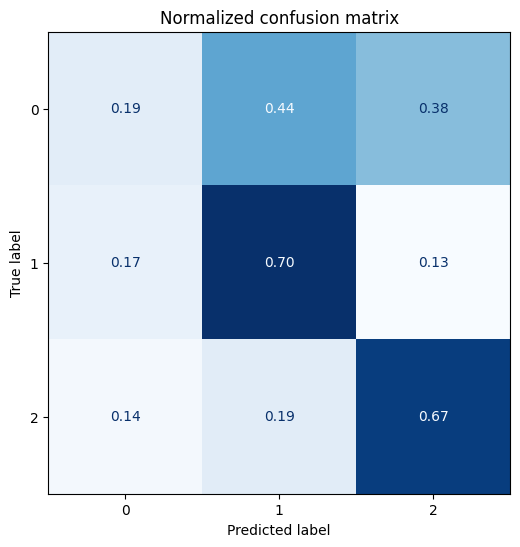

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_preds = np.argmax(tmp_preds_output.predictions, axis=1)
y_valid = np.array(tmp_test_data['labels'])
def plot_confusion_matrix(y_preds, y_true):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid)

#### 評価データを評価する（本番）

In [ ]:
#評価用のモデル/トークナイザ/コンフィグの読み込み
checkpoint = trainer.state.best_model_checkpoint
#checkpoint = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_rubric_task_train_and_eval/checkpoint-50"#BATCH_SIZE=128の時
#checkpoint = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_rubric_task_train_and_eval/checkpoint-200"#BATCH_SIZE=32の時
print(checkpoint)

best_rubric_model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
best_tokenizer = BertTokenizer.from_pretrained(checkpoint)

#config関数から呼び出し
best_lc = load_config()
best_config = best_lc.return_config()

/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_rubric_task_train_and_eval/checkpoint-200


In [ ]:
#評価用の関数など読み込み
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, output_dir):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.savefig(output_dir+"confusion_matrix.png")
    plt.show()

def tokenize_basic(batch):
    return best_tokenizer(batch["text"], padding=True, truncation=True)

Map:   0%|          | 0/244 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           2       0.08      0.19      0.11        16
           1       0.75      0.70      0.72       118
           0       0.78      0.67      0.72       110

    accuracy                           0.66       244
   macro avg       0.54      0.52      0.52       244
weighted avg       0.72      0.66      0.68       244



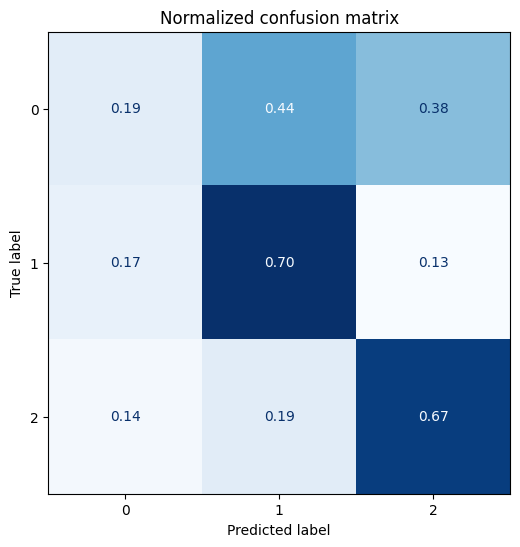

Map:   0%|          | 0/244 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           2       0.03      0.06      0.04        17
           1       0.71      0.61      0.65       117
           0       0.70      0.69      0.70       110

    accuracy                           0.61       244
   macro avg       0.48      0.45      0.46       244
weighted avg       0.66      0.61      0.63       244



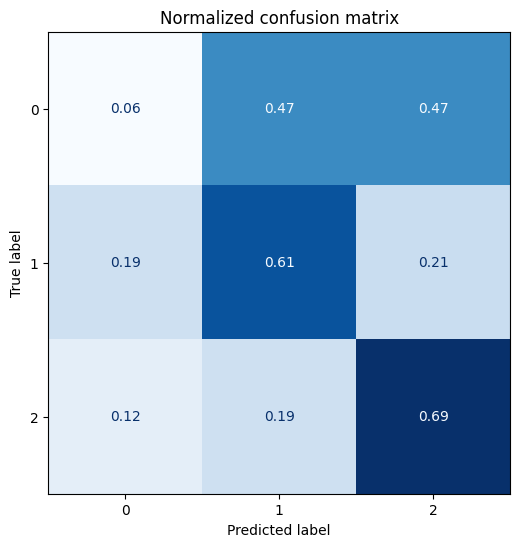

Map:   0%|          | 0/244 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           2       0.05      0.06      0.05        17
           1       0.69      0.68      0.68       117
           0       0.68      0.66      0.67       110

    accuracy                           0.63       244
   macro avg       0.47      0.47      0.47       244
weighted avg       0.64      0.63      0.63       244



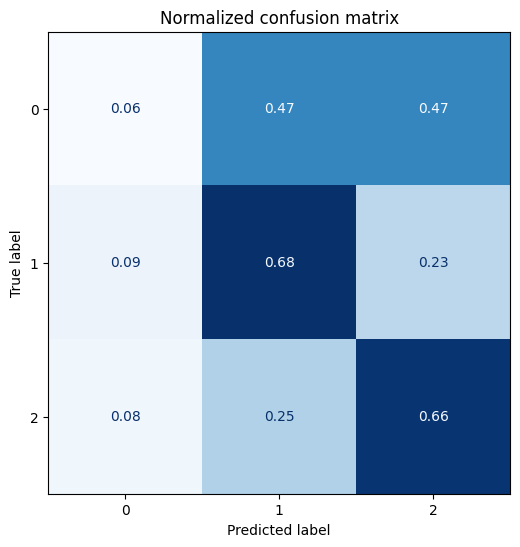

Map:   0%|          | 0/244 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           2       0.11      0.18      0.13        17
           1       0.67      0.69      0.68       117
           0       0.67      0.58      0.62       110

    accuracy                           0.61       244
   macro avg       0.48      0.48      0.48       244
weighted avg       0.63      0.61      0.62       244



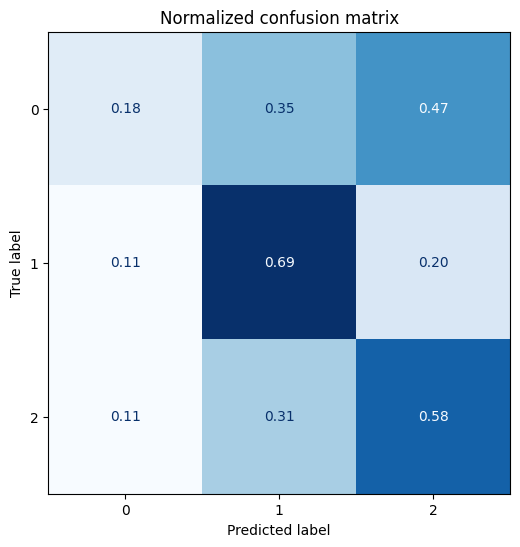

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           2       0.09      0.19      0.12        16
           1       0.70      0.72      0.71       118
           0       0.77      0.61      0.68       109

    accuracy                           0.64       243
   macro avg       0.52      0.51      0.50       243
weighted avg       0.69      0.64      0.66       243



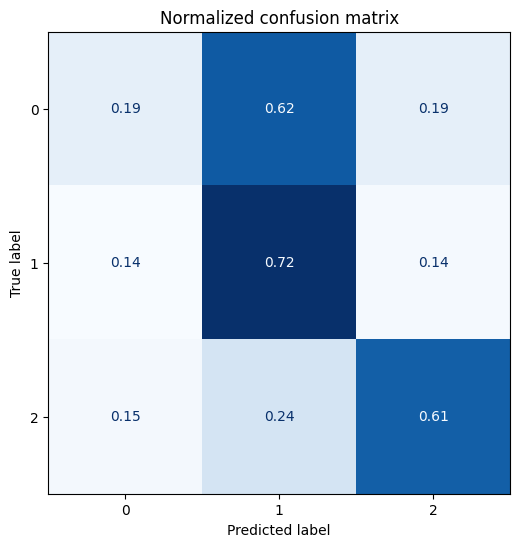

In [ ]:
#評価

#出力ディレクトリの準備
BASE_DATA_DIR = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study1/study1_answer_task_train_and_eval/"
BASE_RESULT_DIR = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study1/study1_rubric_task_train_and_eval/"

for num_fold in range(5):
  #テストデータの読み込み
  cur_fold_num = str(num_fold)
  cur_fold = "Fold" + cur_fold_num
  cur_test_data_dir = BASE_DATA_DIR + cur_fold + "/data_test.csv"
  cur_test_data = pd.read_csv(cur_test_data_dir)

  #データセットの準備
  cur_dataset = Dataset.from_pandas(cur_test_data)
  cur_dataset = cur_dataset.map(tokenize_basic, batched=True, batch_size=None)

  #データの評価
  cur_preds_output = trainer.predict(cur_dataset)

  #評価結果の保存
  cur_test_data['predict'] = cur_preds_output.predictions.argmax(axis=1).tolist()
  cur_categories = cur_test_data['labels'].unique().tolist()
  cur_categories = list(map(str, cur_categories))
  y_preds = np.argmax(cur_preds_output.predictions, axis=1)
  y_valid = np.array(cur_test_data['labels'])

  classification_report_txt = classification_report(y_valid, y_preds, target_names=categories)
  print(classification_report_txt)

  #評価結果を保存するためのディレクトリの作成
  result_output_dir = BASE_RESULT_DIR + "Fold" + str(num_fold) + "/"
  if not os.path.exists(result_output_dir):
    os.makedirs(result_output_dir)

  #confusion_matrixの表示と保存
  plot_confusion_matrix(cur_test_data["predict"], cur_test_data["labels"], result_output_dir)

  #評価結果の保存
  with open(result_output_dir + "classification_report.txt", "w") as output_file:
    output_file.write(classification_report_txt)

  #評価データの保存
  cur_test_data.to_csv(result_output_dir+"data_test.csv", index=False)